
🔁 Training with 1 epochs
Epoch 1: {'ner': 28605.68718876025}
✅ Saved: 02_Model/epoch_testing/ner_model_1_epochs
✅ Saved: 02_Model/epoch_testing/ner_model_1_epochs_plus_entityruler (with EntityRuler)

🔁 Training with 2 epochs
Epoch 1: {'ner': 28419.01329721323}
Epoch 2: {'ner': 10365.925801378}
✅ Saved: 02_Model/epoch_testing/ner_model_2_epochs
✅ Saved: 02_Model/epoch_testing/ner_model_2_epochs_plus_entityruler (with EntityRuler)

🔁 Training with 3 epochs
Epoch 1: {'ner': 28558.739351273234}
Epoch 2: {'ner': 10596.349632161498}
Epoch 3: {'ner': 5994.519803033364}
✅ Saved: 02_Model/epoch_testing/ner_model_3_epochs
✅ Saved: 02_Model/epoch_testing/ner_model_3_epochs_plus_entityruler (with EntityRuler)

🔁 Training with 4 epochs
Epoch 1: {'ner': 28921.019846798612}
Epoch 2: {'ner': 10764.202148251243}
Epoch 3: {'ner': 5932.5494941224215}
Epoch 4: {'ner': 3940.6104134152692}
✅ Saved: 02_Model/epoch_testing/ner_model_4_epochs
✅ Saved: 02_Model/epoch_testing/ner_model_4_epochs_plus_entityruler

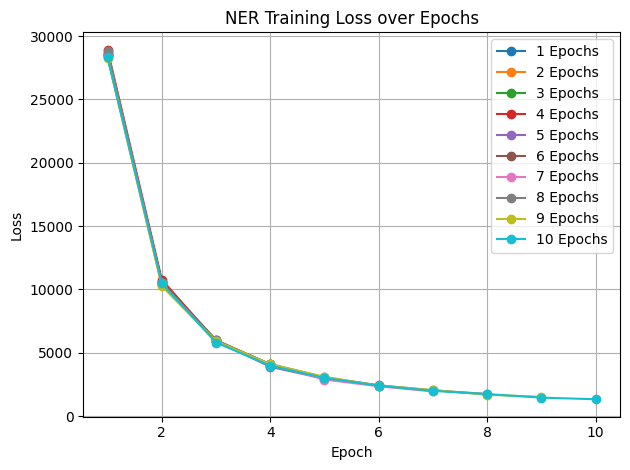

In [1]:
import spacy
import random
import json
import os
import matplotlib.pyplot as plt
from spacy.util import minibatch
from spacy.training.example import Example
from spacy.pipeline import EntityRuler
from spacy.lookups import Lookups
from pathlib import Path
from tqdm import tqdm

# === Lade Trainingsdaten ===
with open("03_Label/spacy_training_data_sentences_v5_new_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

training_data = [
    (item["text"], {"entities": [tuple(ent) for ent in item["entities"]]})
    for item in raw_data
]

# === Lade EntityRuler-Daten ===
with open("03_Label/gemeinden_labels_v4.json", "r", encoding="utf-8") as f:
    ruler_data = json.load(f)
ruler_patterns = [{"label": "LOC", "pattern": entry["label"]} for entry in ruler_data]

# === lexeme_norm Tabelle ===
lexeme_norm_data = {
    "Gemeinden": "Gemeinde",
    "Kantons": "Kanton",
    "Kantone": "Kanton",
    "Bezirke": "Bezirk",
}

# === Trainiere Modelle mit 1–10 Epochen ===
for epoch_count in range(1, 11):
    print(f"\n🔁 Training with {epoch_count} epochs")

    # Starte mit neuem Basis-Modell
    nlp = spacy.load("de_core_news_lg")

    # === Lookups hinzufügen ===
    lookups = Lookups()
    lookups.add_table("lexeme_norm", lexeme_norm_data)
    nlp.vocab.lookups = lookups

    ner = nlp.get_pipe("ner")

    # Labels hinzufügen
    for _, ann in training_data:
        for ent in ann["entities"]:
            ner.add_label(ent[2])

    # Beispiele vorbereiten
    examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in training_data]

    # Training starten
    loss_history = []
    with nlp.disable_pipes(*[p for p in nlp.pipe_names if p != "ner"]):
        optimizer = nlp.resume_training()
        for epoch in range(epoch_count):
            random.shuffle(examples)
            losses = {}
            for batch in minibatch(examples, size=64):
                nlp.update(batch, sgd=optimizer, drop=0.3, losses=losses)
            print(f"Epoch {epoch + 1}: {losses}")
            loss_history.append(losses.get("ner", 0))

    # Modellpfade definieren
    base_path = f"02_Model/epoch_testing/ner_model_{epoch_count}_epochs"
    plus_path = f"{base_path}_plus_entityruler"
    Path(base_path).mkdir(parents=True, exist_ok=True)

    # Modell ohne EntityRuler speichern
    nlp.to_disk(base_path)
    with open(f"{base_path}/loss.json", "w") as f:
        json.dump(loss_history, f)
    print(f"✅ Saved: {base_path}")

    # === Modell mit EntityRuler erstellen ===
    nlp_plus = spacy.load(base_path)

    # Lookups erneut setzen (nach Laden)
    lookups = Lookups()
    lookups.add_table("lexeme_norm", lexeme_norm_data)
    nlp_plus.vocab.lookups = lookups

    ruler = EntityRuler(nlp_plus, overwrite_ents=False)
    ruler.add_patterns(ruler_patterns)
    nlp_plus.add_pipe("entity_ruler", before="ner")
    nlp_plus.to_disk(plus_path)
    print(f"✅ Saved: {plus_path} (with EntityRuler)")

    # === Loss-Kurve vorbereiten ===


In [17]:
import os
import pandas as pd
import spacy
import time

# === Parameter ===
statistic_dataset = "05_Statistik/statistical_test_dataset_data_v5.csv"
model_dir = "02_Model/epoch_testing"
output_csv = "05_Statistik/statistical_test_dataset_data_v5_all_models.csv"

# === CSV laden ===
df = pd.read_csv(statistic_dataset)

# === Hilfsfunktion: LOC-Entitäten extrahieren ===
def extract_spacy_entities(text, model):
    if pd.isna(text):
        return []
    doc = model(text)
    return [ent.text for ent in doc.ents if ent.label_ == "LOC"]

# === Alle Modellverzeichnisse durchlaufen ===
model_paths = sorted([
    name for name in os.listdir(model_dir)
    if os.path.isdir(os.path.join(model_dir, name))
])

print(f"🔍 Gefundene Modelle: {model_paths}")

# === Für jedes Modell Ergebnisse extrahieren ===
for model_name in model_paths:
    print(f"\n🚀 Verarbeite Modell: {model_name}")
    model_path = os.path.join(model_dir, model_name)

    try:
        nlp = spacy.load(model_path)
    except Exception as e:
        print(f"❌ Fehler beim Laden von {model_name}: {e}")
        continue

    loc_labels = []
    start = time.perf_counter()
    for _, row in df.iterrows():
        text = f"{row.get('dataset_title_de', '')} {row.get('dataset_description_de', '')}"
        loc_labels.append(extract_spacy_entities(text, nlp))
    end = time.perf_counter()

    df[model_name] = loc_labels
    print(f"✅ Fertig in {end - start:.2f} Sekunden – Ergebnisse gespeichert in Spalte '{model_name}'")

# === CSV speichern ===
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"\n✅ Alle Ergebnisse gespeichert unter: {output_csv}")


🔍 Gefundene Modelle: ['ner_model_10_epochs', 'ner_model_10_epochs_plus_entityruler', 'ner_model_1_epochs', 'ner_model_1_epochs_plus_entityruler', 'ner_model_2_epochs', 'ner_model_2_epochs_plus_entityruler', 'ner_model_3_epochs', 'ner_model_3_epochs_plus_entityruler', 'ner_model_4_epochs', 'ner_model_4_epochs_plus_entityruler', 'ner_model_5_epochs', 'ner_model_5_epochs_plus_entityruler', 'ner_model_6_epochs', 'ner_model_6_epochs_plus_entityruler', 'ner_model_7_epochs', 'ner_model_7_epochs_plus_entityruler', 'ner_model_8_epochs', 'ner_model_8_epochs_plus_entityruler', 'ner_model_9_epochs', 'ner_model_9_epochs_plus_entityruler']

🚀 Verarbeite Modell: ner_model_10_epochs
✅ Fertig in 1.62 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_10_epochs'

🚀 Verarbeite Modell: ner_model_10_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.13 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_10_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_1_epochs
✅ Fertig in 2.46 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_1_epochs'

🚀 Verarbeite Modell: ner_model_1_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.39 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_1_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_2_epochs
✅ Fertig in 5.37 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_2_epochs'

🚀 Verarbeite Modell: ner_model_2_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.30 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_2_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_3_epochs
✅ Fertig in 2.16 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_3_epochs'

🚀 Verarbeite Modell: ner_model_3_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.27 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_3_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_4_epochs
✅ Fertig in 2.19 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_4_epochs'

🚀 Verarbeite Modell: ner_model_4_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.42 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_4_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_5_epochs
✅ Fertig in 2.31 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_5_epochs'

🚀 Verarbeite Modell: ner_model_5_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.45 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_5_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_6_epochs
✅ Fertig in 2.81 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_6_epochs'

🚀 Verarbeite Modell: ner_model_6_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.00 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_6_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_7_epochs
✅ Fertig in 1.88 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_7_epochs'

🚀 Verarbeite Modell: ner_model_7_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 1.84 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_7_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_8_epochs
✅ Fertig in 2.72 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_8_epochs'

🚀 Verarbeite Modell: ner_model_8_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 1.88 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_8_epochs_plus_entityruler'

🚀 Verarbeite Modell: ner_model_9_epochs
✅ Fertig in 1.83 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_9_epochs'

🚀 Verarbeite Modell: ner_model_9_epochs_plus_entityruler


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

✅ Fertig in 2.00 Sekunden – Ergebnisse gespeichert in Spalte 'ner_model_9_epochs_plus_entityruler'

✅ Alle Ergebnisse gespeichert unter: 05_Statistik/statistical_test_dataset_data_v5_all_models.csv


c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does not have any patterns defined.
  warnings.warn(Warnings.W036.format(name=self.name))
c:\Users\fabia\anaconda3\lib\site-packages\spacy\pipeline\entityruler.py:405: UserWarning: [W036] The component 'entity_ruler' does 

In [9]:
import pandas as pd
import ast
import re

# === CSV laden ===
comparison_csv = "05_Statistik/statistical_test_dataset_data_v5_all_models.csv"
df = pd.read_csv(comparison_csv)

# === Hilfsfunktionen ===

def parse_location_string(value):
    """Verwandelt einen String wie 'Kt SG, Kaltbrunn' in ['Kt SG', 'Kaltbrunn']"""
    if isinstance(value, list):
        return value
    if pd.isna(value):
        return ['not_found']
    parts = re.split(r"[,/]", str(value))
    parts = [part.strip() for part in parts if part.strip()]
    return parts if parts else ['not_found']

def to_list_if_needed(value):
    """Für Modellspalten: evaluiert echte Python-Listen-Strings"""
    if isinstance(value, list):
        return value
    try:
        parsed = ast.literal_eval(value)
        if isinstance(parsed, list):
            return parsed
    except Exception as e:  
        print(f"❌ Fehler beim Parsen: {value} → {e}")
    return []

def clean_label_list(label_list):
    """Reinigt Begriffe wie 'Gemeinde', teilt auf, normalisiert"""
    if not isinstance(label_list, list):
        return []
    cleaned = []
    for label in label_list:
        if not isinstance(label, str):
            continue
        label = label.strip("'\"")  # Anführungszeichen außen entfernen
        label = label.replace("Gemeinde", "")
        label = label.replace("Stadt", "")
        label = label.replace("Kantons", "")
        label = label.replace("Kanton", "")
        label = label.replace("Kt", "")
        parts = re.split(r"[,/]", label)
        for part in parts:
            part = part.strip().lower()
            if part and part != "av":
                cleaned.append(part)
    return list(dict.fromkeys(cleaned))  # Duplikate entfernen

# === Modellspalten erkennen ===
model_columns = [col for col in df.columns if col.startswith("ner_model_")]
print(f"🔍 Gefundene Modellspalten: {model_columns}")

# === correct_location + semantic_location bereinigen
if "correct_location" in df.columns:
    df["correct_location"] = df["correct_location"].apply(parse_location_string).apply(clean_label_list)

if "semantic_location" in df.columns:
    df["semantic_location"] = df["semantic_location"].apply(parse_location_string).apply(clean_label_list)

# === Alle Modellspalten bereinigen
for col in model_columns:
    df[col] = df[col].apply(to_list_if_needed).apply(clean_label_list)

# === Leere Listen in Modellspalten durch ['not_found'] ersetzen ===
for col in model_columns:
    df[col] = df[col].apply(lambda x: ['not_found'] if not x else x)



# Hilfsfunktion zum Entfernen einzelner Satzzeichen
def clean_text(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r"[^\wäöüÄÖÜß\s]", "", text)


# Bereinigen und zusammenführen
df["all_words"] = (df["dataset_title_de"].apply(clean_text) + " " + df["dataset_description_de"].apply(clean_text)).str.split()


# === Speichern ===
df.to_csv(comparison_csv, index=False, encoding="utf-8")
print(f"\n✅ Bereinigte Daten gespeichert unter: {comparison_csv}")


🔍 Gefundene Modellspalten: ['ner_model_10_epochs', 'ner_model_10_epochs_plus_entityruler', 'ner_model_1_epochs', 'ner_model_1_epochs_plus_entityruler', 'ner_model_2_epochs', 'ner_model_2_epochs_plus_entityruler', 'ner_model_3_epochs', 'ner_model_3_epochs_plus_entityruler', 'ner_model_4_epochs', 'ner_model_4_epochs_plus_entityruler', 'ner_model_5_epochs', 'ner_model_5_epochs_plus_entityruler', 'ner_model_6_epochs', 'ner_model_6_epochs_plus_entityruler', 'ner_model_7_epochs', 'ner_model_7_epochs_plus_entityruler', 'ner_model_8_epochs', 'ner_model_8_epochs_plus_entityruler', 'ner_model_9_epochs', 'ner_model_9_epochs_plus_entityruler']

✅ Bereinigte Daten gespeichert unter: 05_Statistik/statistical_test_dataset_data_v5_all_models.csv


🔍 Gefundene Modellspalten: ['ner_model_10_epochs', 'ner_model_10_epochs_plus_entityruler', 'ner_model_1_epochs', 'ner_model_1_epochs_plus_entityruler', 'ner_model_2_epochs', 'ner_model_2_epochs_plus_entityruler', 'ner_model_3_epochs', 'ner_model_3_epochs_plus_entityruler', 'ner_model_4_epochs', 'ner_model_4_epochs_plus_entityruler', 'ner_model_5_epochs', 'ner_model_5_epochs_plus_entityruler', 'ner_model_6_epochs', 'ner_model_6_epochs_plus_entityruler', 'ner_model_7_epochs', 'ner_model_7_epochs_plus_entityruler', 'ner_model_8_epochs', 'ner_model_8_epochs_plus_entityruler', 'ner_model_9_epochs', 'ner_model_9_epochs_plus_entityruler']


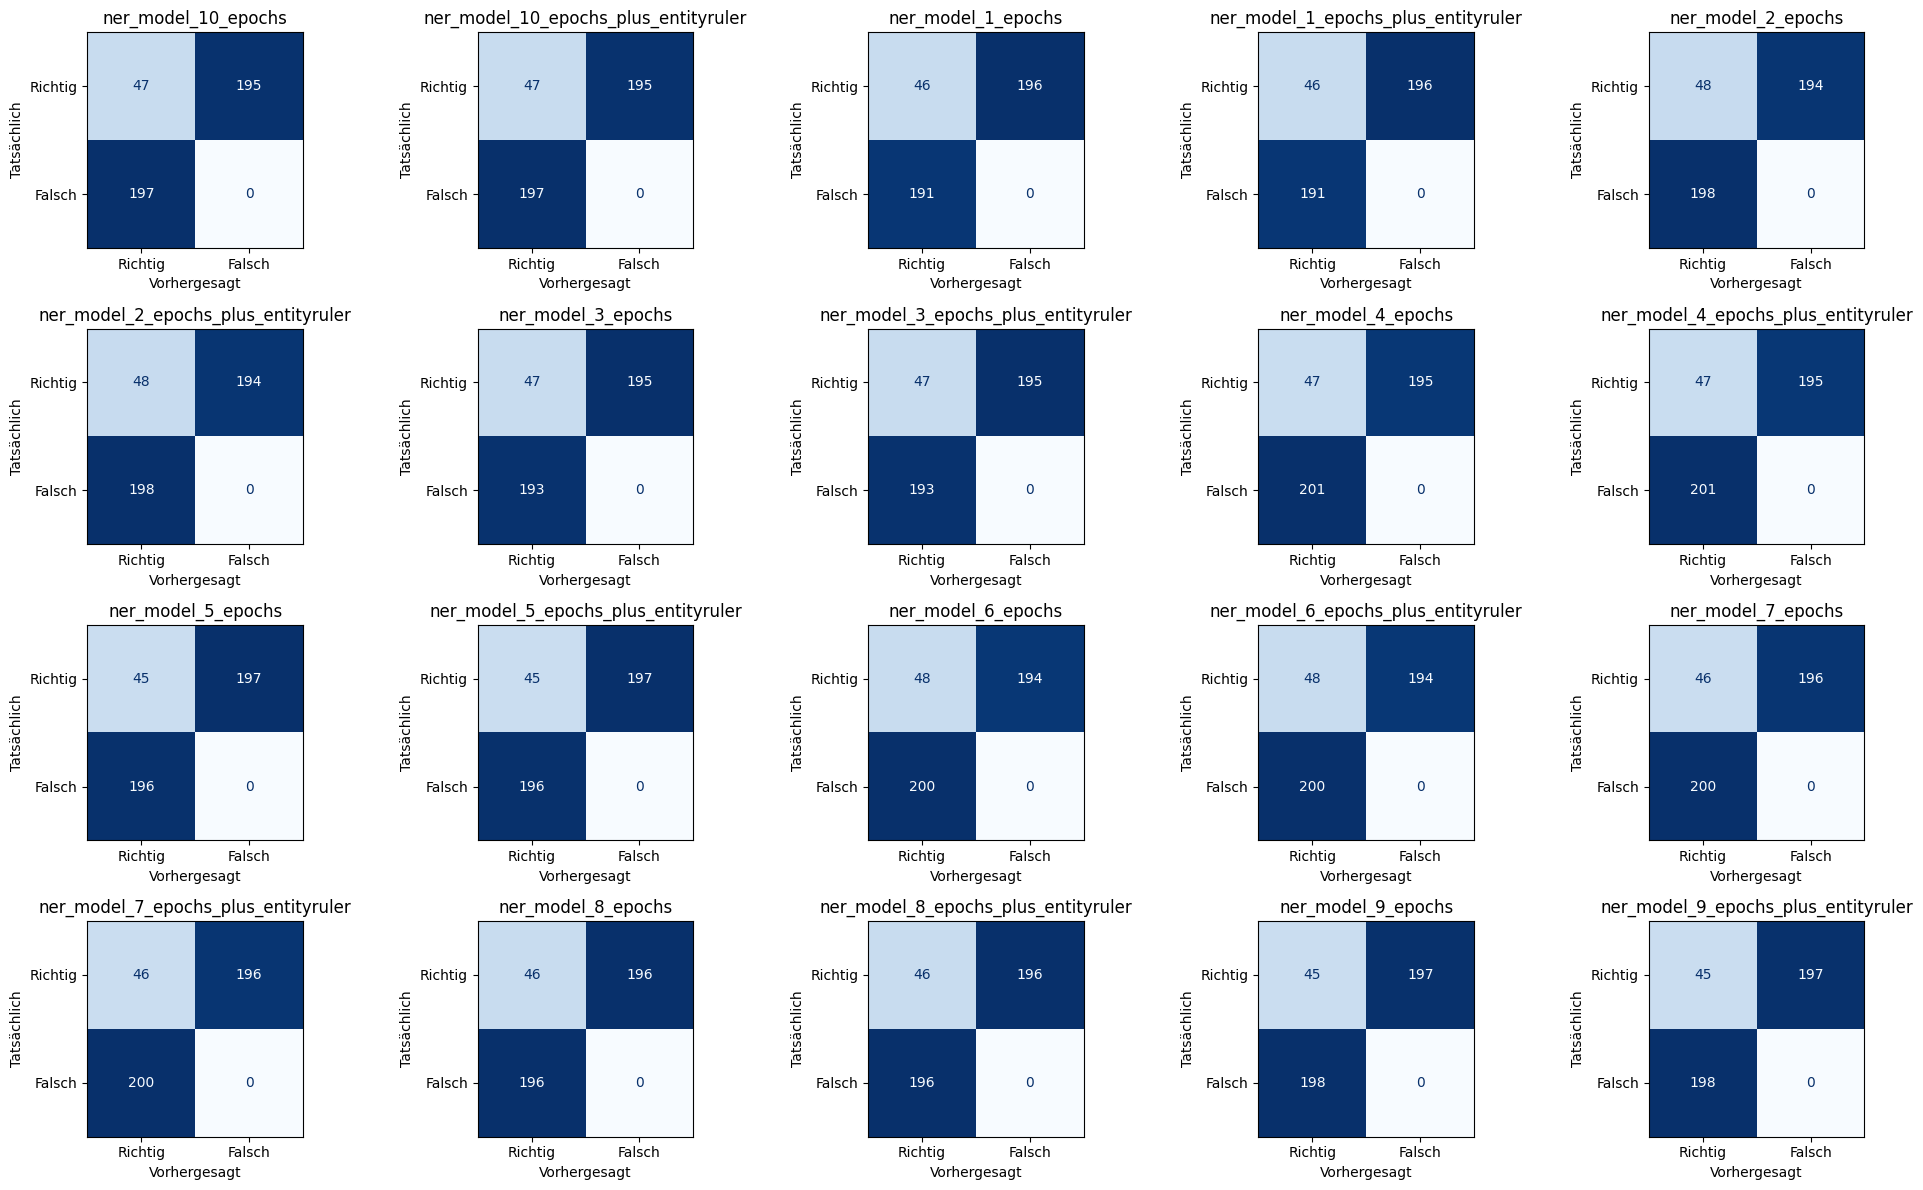

✅ Konfusionsmatrix gespeichert unter: 05_Statistik/konfusionsmatrizen_loc_erkennung_data_all_models.png
✅ Precision/Recall/F1 gespeichert unter: 05_Statistik/loc_scores_data_all_models.csv
✅ Zusammenfassung mit Accuracy gespeichert unter: 05_Statistik/loc_scores_summary_all_models.csv


In [13]:
import pandas as pd
import ast
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# === Parameter ===
comparison_csv = "05_Statistik/statistical_test_dataset_data_v5_all_models.csv"
version = "all_models"
image_path = f"05_Statistik/konfusionsmatrizen_loc_erkennung_data_{version}.png"
score_path = f"05_Statistik/loc_scores_data_{version}.csv"
summary_path = f"05_Statistik/loc_scores_summary_{version}.csv"

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === Hilfsfunktionen ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

def normalize_list(liste):
    return [str(item).strip().lower() for item in liste if isinstance(item, str)]

def precision_recall_f1_accuracy(predicted, actual, label_space):
    pred_set = set(normalize_list(predicted))
    actual_set = set(normalize_list(actual))

    tp = len(pred_set & actual_set)
    fp = len(pred_set - actual_set)
    fn = len(actual_set - pred_set)
    tn = len(label_space - pred_set - actual_set)

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) else 0

    return precision, recall, f1, accuracy

# === Spalten vorbereiten ===
df["correct_location"] = df["correct_location"].apply(to_list)
df["all_words"] = df["all_words"].apply(to_list).apply(normalize_list)

# === Modellspalten erkennen und vorbereiten ===
model_columns = [col for col in df.columns if col.startswith("ner_model_")]
print(f"🔍 Gefundene Modellspalten: {model_columns}")
for col in model_columns:
    df[col] = df[col].apply(to_list)

# === Konfusionsmatrizen + tokenbasierte Genauigkeit ===
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
axes = axes.flatten()

results = []
summary_data = []

for idx, col in enumerate(model_columns):
    name = col

    # === Konfusionsmatrix berechnen ===
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        true_set = set(normalize_list(row["correct_location"]))
        pred_set = set(normalize_list(row[col]))
        label_union = true_set.union(pred_set)
        for label in label_union:
            y_true.append(label in true_set)
            y_pred.append(label in pred_set)

    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Richtig", "Falsch"])
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Vorhergesagt")
    axes[idx].set_ylabel("Tatsächlich")

    # === Dokumentbasierte Scores ===
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # === Tokenbasierte Scores pro Zeile mit Zeilen-Labelraum
    df[[f"precision_{name}", f"recall_{name}", f"f1_{name}", f"accuracy_{name}"]] = df.apply(
        lambda row: pd.Series(
            precision_recall_f1_accuracy(
                row[col], 
                row["correct_location"], 
                set(row["all_words"])
            )
        ),
        axis=1
    )

    # === Durchschnittswerte berechnen
    summary_data.append({
        "Methode": name,
        "Precision": df[f"precision_{name}"].mean(),
        "Recall": df[f"recall_{name}"].mean(),
        "F1-Score": df[f"f1_{name}"].mean(),
        "Accuracy": df[f"accuracy_{name}"].mean()
    })

    results.append({
        "Methode": name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# === Grafik speichern ===
plt.tight_layout()
plt.savefig(image_path, dpi=300)
plt.show()
print(f"✅ Konfusionsmatrix gespeichert unter: {image_path}")

# === Ergebnisse speichern ===
pd.DataFrame(results).to_csv(score_path, index=False)
pd.DataFrame(summary_data).round(3).to_csv(summary_path, index=False)

print(f"✅ Precision/Recall/F1 gespeichert unter: {score_path}")
print(f"✅ Zusammenfassung mit Accuracy gespeichert unter: {summary_path}")


🔍 Gefundene Modellspalten: ['ner_model_10_epochs', 'ner_model_10_epochs_plus_entityruler', 'ner_model_1_epochs', 'ner_model_1_epochs_plus_entityruler', 'ner_model_2_epochs', 'ner_model_2_epochs_plus_entityruler', 'ner_model_3_epochs', 'ner_model_3_epochs_plus_entityruler', 'ner_model_4_epochs', 'ner_model_4_epochs_plus_entityruler', 'ner_model_5_epochs', 'ner_model_5_epochs_plus_entityruler', 'ner_model_6_epochs', 'ner_model_6_epochs_plus_entityruler', 'ner_model_7_epochs', 'ner_model_7_epochs_plus_entityruler', 'ner_model_8_epochs', 'ner_model_8_epochs_plus_entityruler', 'ner_model_9_epochs', 'ner_model_9_epochs_plus_entityruler']


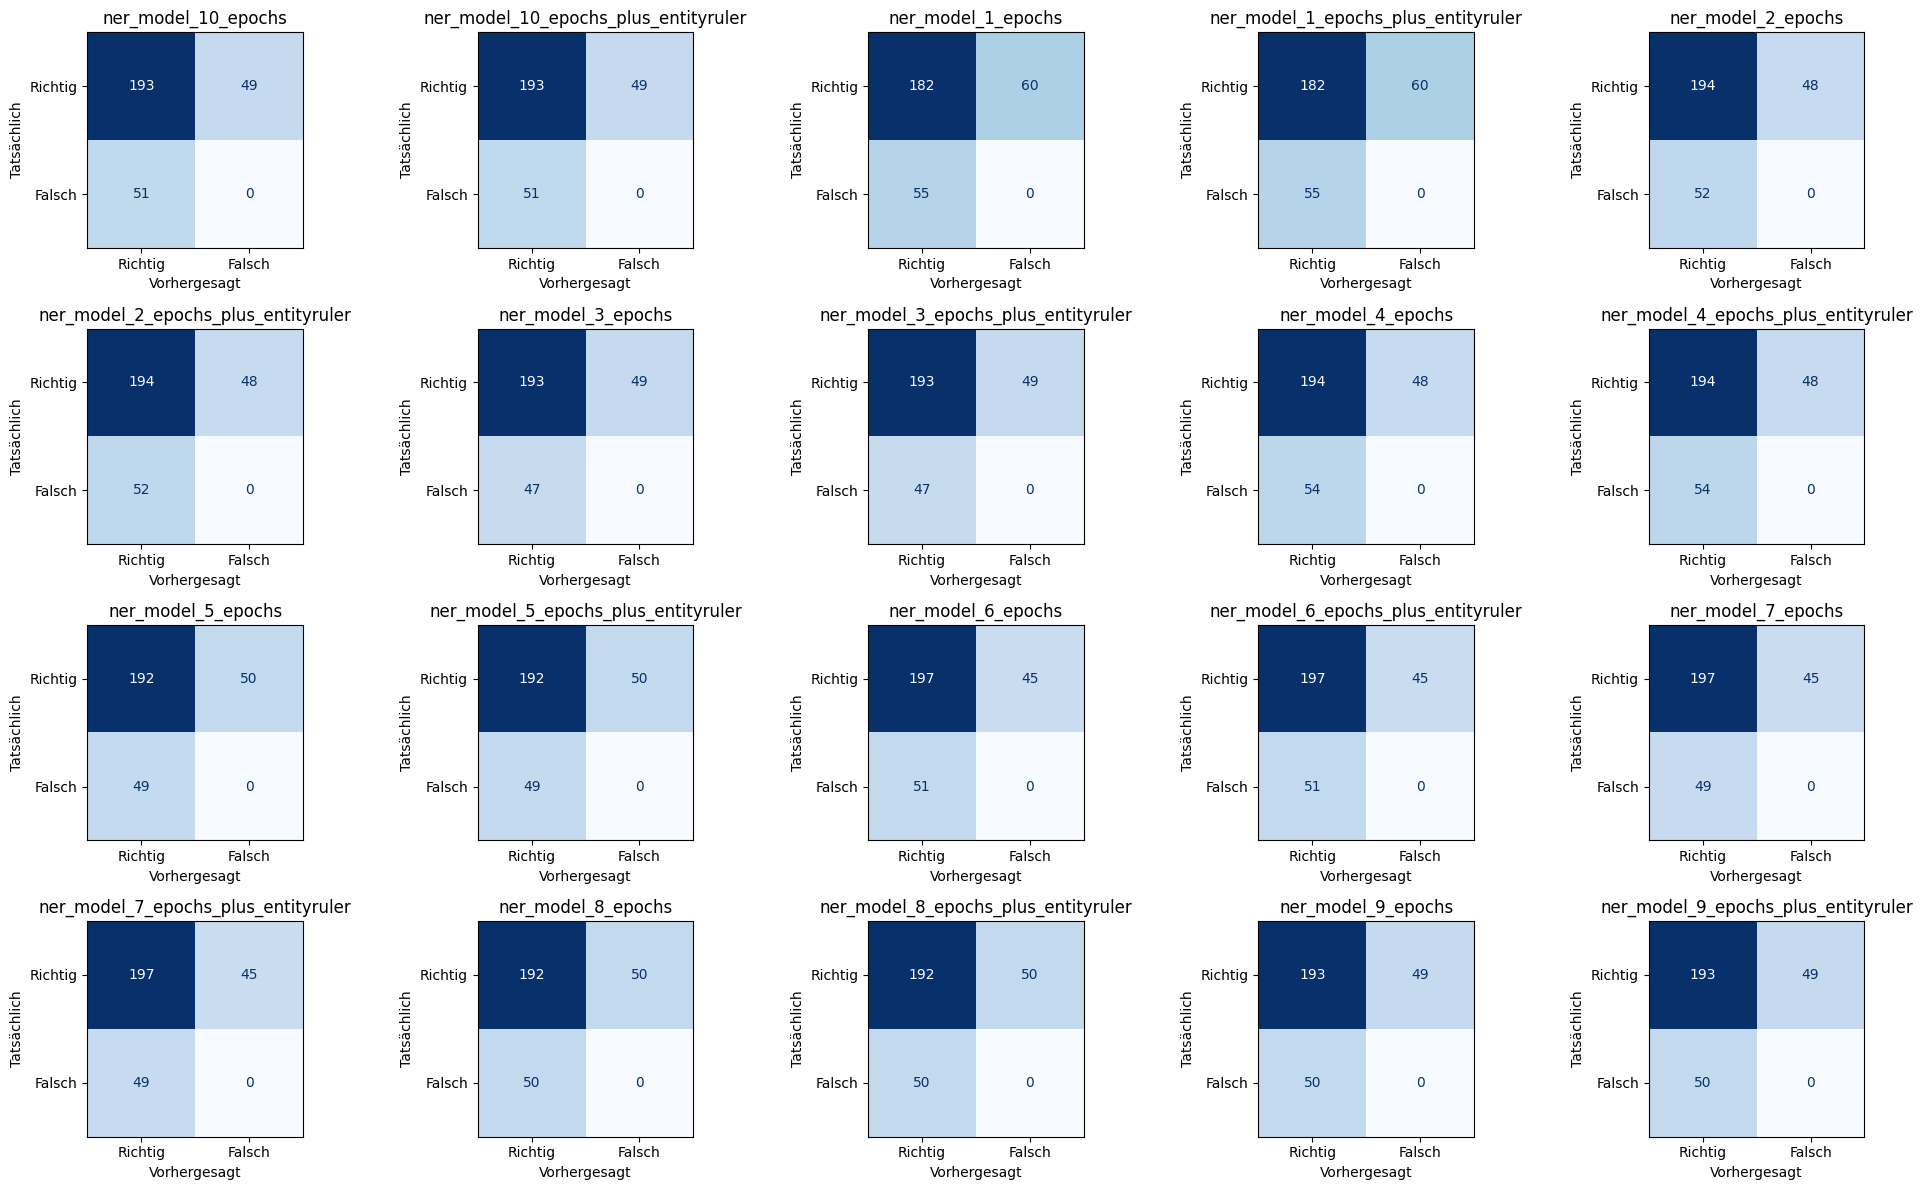

✅ Konfusionsmatrix gespeichert unter: 05_Statistik/konfusionsmatrizen_loc_erkennung_data_all_models.png
✅ Precision/Recall/F1 gespeichert unter: 05_Statistik/loc_scores_data_all_models.csv


In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import ast
import os

# === Parameter ===
comparison_csv = "05_Statistik/statistical_test_dataset_data_v5_all_models.csv"
version = "all_models"
image_path = f"05_Statistik/konfusionsmatrizen_loc_erkennung_data_{version}.png"
score_path = f"05_Statistik/loc_scores_data_{version}.csv"

# === CSV laden ===
df = pd.read_csv(comparison_csv)

# === Helfer: String -> Liste ===
def to_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    try:
        return ast.literal_eval(val)
    except:
        return [str(val).strip()]

# === Relevante Spalten in Listen umwandeln ===
df["correct_location"] = df["correct_location"].apply(to_list)

# === Modellspalten automatisch erkennen ===
model_columns = [col for col in df.columns if col.startswith("ner_model_")]
print(f"🔍 Gefundene Modellspalten: {model_columns}")

for col in model_columns:
    df[col] = df[col].apply(to_list)

# === Token-Ebene Vergleichsfunktion ===
def get_true_pred_pairs(df, pred_col):
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        true_set = set(map(str.lower, row["correct_location"]))
        pred_set = set(map(str.lower, row[pred_col]))
        all_labels = true_set.union(pred_set)
        for label in all_labels:
            y_true.append(label in true_set)
            y_pred.append(label in pred_set)
    return y_true, y_pred

# === Konfusionsmatrizen und Scores ===
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
axes = axes.flatten()  # Flatten to easily iterate over axes


results = []

for idx, col in enumerate(model_columns):
    name = col  # Modellname direkt aus Spaltennamen
    y_true, y_pred = get_true_pred_pairs(df, col)
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Richtig", "Falsch"])
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Vorhergesagt")
    axes[idx].set_ylabel("Tatsächlich")

    # Scores berechnen
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    results.append({"Methode": name, "Precision": precision, "Recall": recall, "F1-Score": f1})

# === Grafik speichern ===
# plt.suptitle("Konfusionsmatrizen – LOC-Erkennung je Modell", fontsize=14)
plt.tight_layout()
plt.savefig(image_path, dpi=300)
plt.show()
print(f"✅ Konfusionsmatrix gespeichert unter: {image_path}")

# === Scores speichern ===
score_df = pd.DataFrame(results)
score_df.to_csv(score_path, index=False)
print(f"✅ Precision/Recall/F1 gespeichert unter: {score_path}")


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the dataset
df = pd.read_csv('05_Statistik/statistical_test_dataset_data_v5_all_models.csv')

# Inspect to determine column structure
print(df.columns)

# Assuming the dataset contains:
# - one ground truth column, e.g., 'true_label'
# - multiple model prediction columns, e.g., 'model1', 'model2', ...
# Adjust these based on actual column names
true_col = 'true_label'  # Change this if necessary
model_cols = [col for col in df.columns if col != true_col]

# Calculate metrics for each model
results = []
for model in model_cols:
    precision = precision_score(df[true_col], df[model], average='weighted', zero_division=0)
    recall = recall_score(df[true_col], df[model], average='weighted', zero_division=0)
    f1 = f1_score(df[true_col], df[model], average='weighted', zero_division=0)
    accuracy = accuracy_score(df[true_col], df[model])
    results.append({
        'model': model,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    })

# Convert to DataFrame and show
results_df = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Metrics", dataframe=results_df)
